# オーディオ分類モデルの勉強
## 参考文献
- https://blog.brainpad.co.jp/entry/2018/04/17/143000
- https://medium.com/@hasithsura/audio-classification-d37a82d6715
- https://github.com/karolpiczak/ESC-50
- https://qiita.com/cvusk/items/61cdbce80785eaf28349
- https://tensorflow.classcat.com/2019/05/02/cc-eager-brains-sound-esc50/
- https://hntk03.hatenablog.com/entry/2019/11/09/142122
- https://qiita.com/martin-d28jp-love/items/34161f2facb80edd999f
- https://qiita.com/kshina76/items/5686923dee2889beba7c
- https://qiita.com/yutalfa/items/dbd172138db60d461a56
- https://qiita.com/Anharu/items/46987e85b68c5d7bab6a


## 説明の流れ
1. 音×DeepLearningについての前置き（はじめに、程度）  
どんなことができるか、ユースケースなどを簡単にまとめる？
1. 音とは？  （物理現象としての音の説明）  
Hzとかサンプルレートとかの説明は入れる  
ステレオとモノラルとは？  
ビットとは？
1. 音の特徴量（スペクトログラムとMFCCが主）
1. 今回のタスク（環境音分類）の説明とその他の参考になりそうなデータセットの紹介
1. 音データの扱い方（librosaの紹介、データ出力の見方）
1. 音データの前処理方法
1. 音データの分類方法
1. 実装例1 単純なCNN（それぞれの特徴量で試したい）
1. 実装例2 ResNetあたり
1. 実装例3 RNN系やったらどうなるか
1. 終わりに

# はじめに

音$\times$DeepLearningに入門しようと、いろいろ勉強してみたので、それらの内容を簡単に書き留めておきます。
あくまでとりあえず実装して動かしてみたい、をモチベーションにしているので、細かな点には触れていないと思いますので、そのへんはご了承ください。

以下の記事を見て勉強しました！

**参考文献**

- https://blog.brainpad.co.jp/entry/2018/04/17/143000
- https://medium.com/@hasithsura/audio-classification-d37a82d6715
- https://github.com/karolpiczak/ESC-50
- https://qiita.com/cvusk/items/61cdbce80785eaf28349
- https://tensorflow.classcat.com/2019/05/02/cc-eager-brains-sound-esc50/
- https://hntk03.hatenablog.com/entry/2019/11/09/142122
- https://qiita.com/martin-d28jp-love/items/34161f2facb80edd999f
- https://qiita.com/kshina76/items/5686923dee2889beba7c
- https://qiita.com/yutalfa/items/dbd172138db60d461a56
- https://qiita.com/Anharu/items/46987e85b68c5d7bab6a
- https://www.nogawanogawa.com/entry/rfcx
- https://qiita.com/shinmura0/items/858214154f889c05e4f4
- https://towardsdatascience.com/getting-to-know-the-mel-spectrogram-31bca3e2d9d0

## Google Driveマウント

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## ライブラリインポート/各種設定

In [2]:
import os
import pandas as pd
from tqdm import tqdm
import librosa
import librosa.display # インポートしないでlibrosa.display(〜〜)で実行しようとするとエラーになりました
import matplotlib.pyplot as plt
import IPython.display as ipd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

以下のデータを扱います。環境音データセットってやつですかね。

- https://github.com/karolpiczak/ESC-50

動物の鳴き声やら雨の音やら車のエンジン音などさまざまな音源が50のカテゴリでまとめられたデータセットです。
音を機械学習で扱おうとする際に実験的によく使われるデータセットだと思われます。
とりあえず、このGitリポジトリをGoogle Drive上などにcloneしておきます。

In [3]:
drive_dir = "drive/My Drive/Colab Notebooks/ESC-50-master/"

## データの確認

In [4]:
# メタファイル（ファイル名にカテゴリーなどが紐づいた情報）がcsvファイルとして格納されているので、DataFrameで持っておく
meta_df = pd.read_csv(drive_dir + "meta/esc50.csv")

# メタファイルを確認する
display(meta_df.head())

# 全カテゴリーを取得して確認する
categories = meta_df['category'].unique()
print("データセットの数", meta_df.shape[0])
print(len(categories), categories[:10]) # いくつかカテゴリーを表示してみる

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


データセットの数 2000
50 ['dog' 'chirping_birds' 'vacuum_cleaner' 'thunderstorm' 'door_wood_knock'
 'can_opening' 'crow' 'clapping' 'fireworks' 'chainsaw']


# librosaで音源データを読み込んで見る

音源データを読み込み、波形を確認したり、モデルに投入する各種特徴量（メルスペクトログラムやMFCCなど）を簡単に取得できるライブラリに`librosa`というものがあります。
これを使って、環境音の波形や特徴量を取得して可視化してみます。
メルスペクトログラムやMFCCについては参考文献をご参照ください。

波形データのデータタイプ <class 'numpy.ndarray'>
メルスペクトログラムのデータタイプ <class 'numpy.ndarray'>
MFCCのデータタイプ <class 'numpy.ndarray'>
サンプルレート 22050
波形データの形状 (110250,)
メルスペクトログラムの形状 (128, 216)
MFCCの形状 (20, 216)
category : drinking_sipping


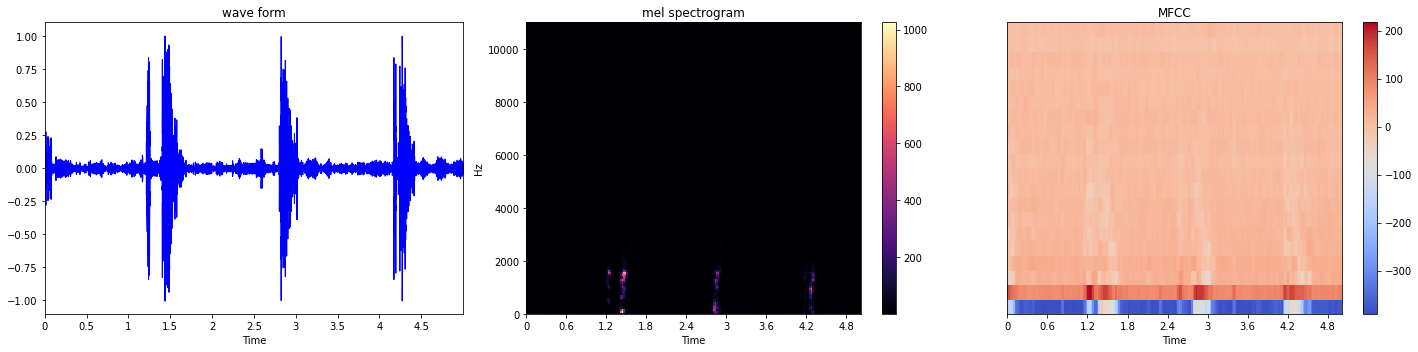

category : snoring


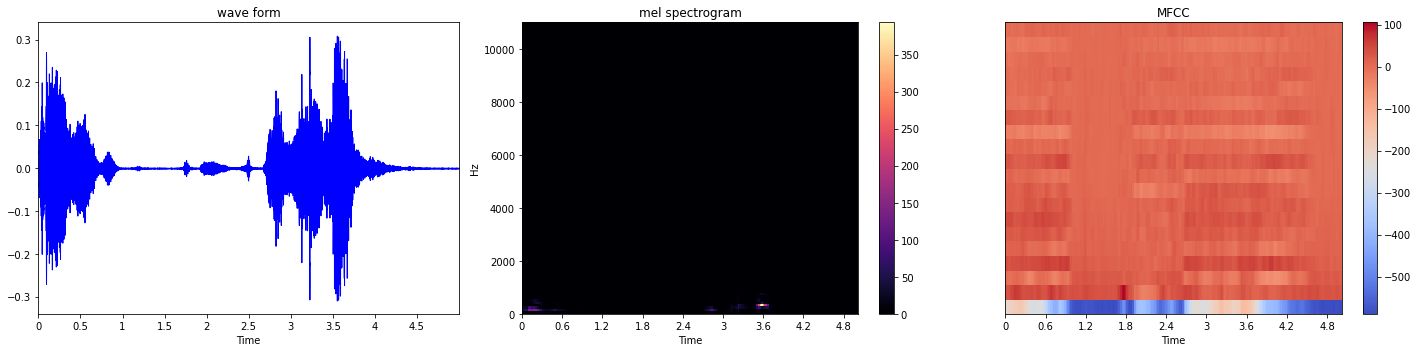

category : pouring_water


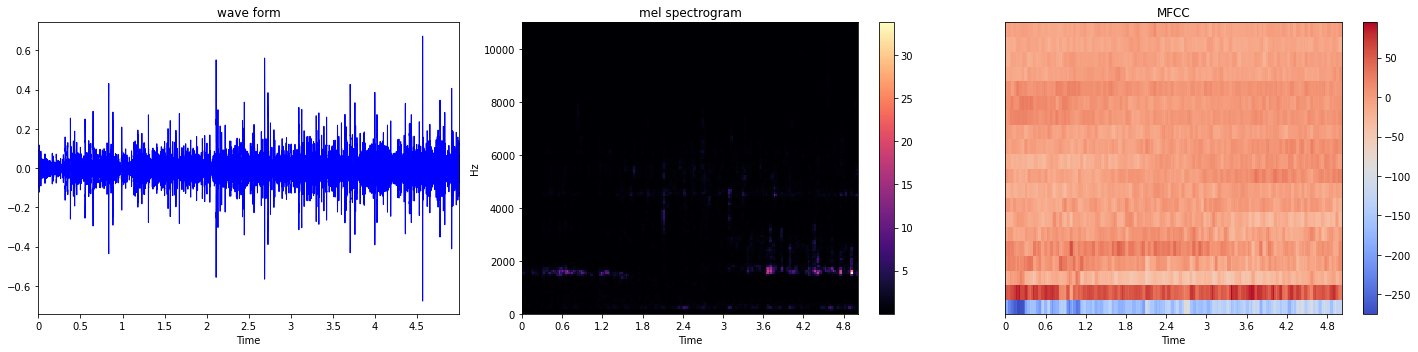

In [9]:
# とりあえず1つの音源ファイルを指定してlibrosaを使ってみる
#librosa.loadで音源の波形データ（第1戻り値）とサンプルレート（第2戻り値）を取得できます。
waveform, sample_rate = librosa.load(drive_dir + "audio/1-100032-A-0.wav") # 犬の鳴き声の音源データを指定

# メルスペクトログラムの取得
# librosa.feature.melspectrogramに上で取得した波形データとサンプルレートを渡せば一発でメルスペクトログラムを取得できます。
feature_melspec = librosa.feature.melspectrogram(y=waveform, sr=sample_rate)

# MFCCの取得
# librosa.feature.mfccでOK
feature_mfcc = librosa.feature.mfcc(y=waveform, sr=sample_rate)

# 波形データ、メルスペクトログラム、MFCCはnumpyで取得されます。
print("波形データのデータタイプ", type(waveform))
print("メルスペクトログラムのデータタイプ", type(feature_melspec))
print("MFCCのデータタイプ", type(feature_mfcc))
print("サンプルレート", sample_rate)
print("波形データの形状", waveform.shape)
print("メルスペクトログラムの形状", feature_melspec.shape)
print("MFCCの形状", feature_mfcc.shape)

# ランダムに3つほど音源データをピックアップして、波形、メルスペクトログラム、MFCCをそれぞれ可視化してみます。
# ついでにnotebook上で音源の再生ができるようにもします。
for row in meta_df.sample(frac=1)[['filename', 'category']][:3].iterrows():
    filename = row[1][0] # wavファイル名
    category = row[1][1] # そのファイルのカテゴリ

    waveform, sample_rate = librosa.load(drive_dir + "audio/" + filename)
    feature_melspec = librosa.feature.melspectrogram(y=waveform, sr=sample_rate)
    feature_mfcc = librosa.feature.mfcc(y=waveform, sr=sample_rate)

    # 可視化
    print("category : " + category)
    plt.figure(figsize=(20, 5))

    # librosa.display.waveplotで波形データを可視化できます
    plt.subplot(1,3,1)
    plt.title("wave form")
    librosa.display.waveplot(waveform, sr=sample_rate, color='blue')

    # librosa.display.specshowでメルスペクトログラム、MFCCを可視化できます
    plt.subplot(1,3,2)
    plt.title("mel spectrogram")
    librosa.display.specshow(feature_melspec, sr=sample_rate, x_axis='time', y_axis='hz')
    plt.colorbar()

    plt.subplot(1,3,3)
    plt.title("MFCC")
    librosa.display.specshow(feature_mfcc, sr=sample_rate, x_axis='time')
    plt.colorbar()

    plt.tight_layout()
    plt.show()
    print()

    # 音源の再生はlibrosaで取得できた波形データとサンプルレートをIPython.display.Audioに以下のようにして渡します。
    display(ipd.Audio(waveform, rate=sample_rate))

上で見るようにメルスペクトログラムやMFCCはある種画像データとみなすことができると思います。
そして、それらを画像とみなした時、隣接するピクセルは密接な関係性があるはずであり、離れたピクセル同士は関係性が薄そうとみなせそう、つまり、CNNが使えそう、ということになるようです。

今回は特徴量としてメルスペクトログラムを用いますが、上で求めたメルスペクトログラムではうまくCNNで分類できませんでした。理由としては上のメルスペクトログラムの画像の黒いところは０付近の値が入ってて、こんなに0付近ばかりだと畳み込んでも0なので、うまく特徴量変換できなさそうなことはイメージがわきます。

そもそもメルスペクトログラムの画像の見方ですが、横軸は時間、縦軸はHz（周波数）になってて、色の濃淡は特定の時間、Hzにおける振幅（つまり音圧）を表しているのですが、人間が知覚する音圧はデシベルスケール（常用対数の10倍）のようで、上で求めたメルスペクトログラムの色の濃淡は人間的にはスケーリングが広すぎるので、デシベルスケールに変換、凝縮することで、より人間の感覚に近いものになるのかと。
濃淡をデシベルスケールにすればメルスペクトログラムを画像と見立てた際も、より濃淡がはっきりした画像になり、CNNでうまく特徴量変換できそうな気がします。

`librosa`でデシベルスケールに変換するには、上で取得したメルスペクトログラムに`librosa.power_to_db`を施せばOKです。

参考記事をいくつか拝見してても、基本`librosa.feature.melspectrogram`でメルスペクトログラムを抽出したあと、`librosa.power_to_db`でデシベルスケールに変換したものをメルスペクトログラムと紹介されているのはこういうことなのかと。スペクトログラムの縦軸（Hz）を人間の知覚に合わせてメルスケール（log）で変換して、さらに音圧もデシベルスケール（log）に変換、と対数変換を2回行っているイメージですかね。（この辺の理解に苦戦しました。間違っていたらご指摘ください〜）


ってことで、メルスペクトログラムをデシベルスケールに変換したものの可視化結果は以下のようになります。よりCNNが機能しそうな画像に確かになってますね。

category : crickets


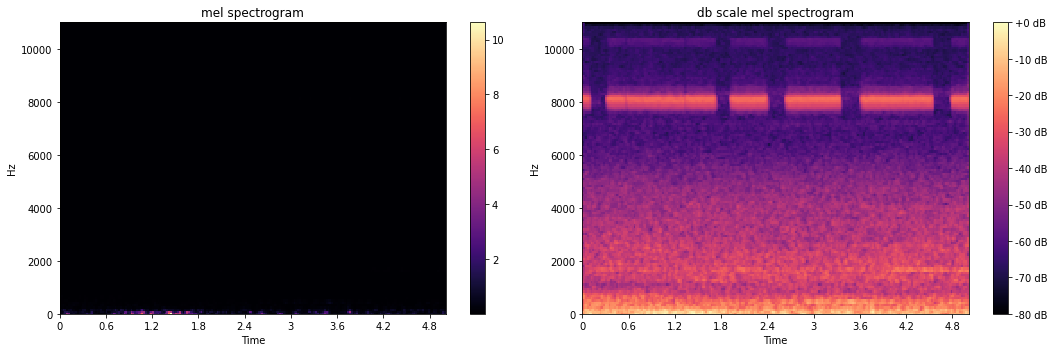

category : hen


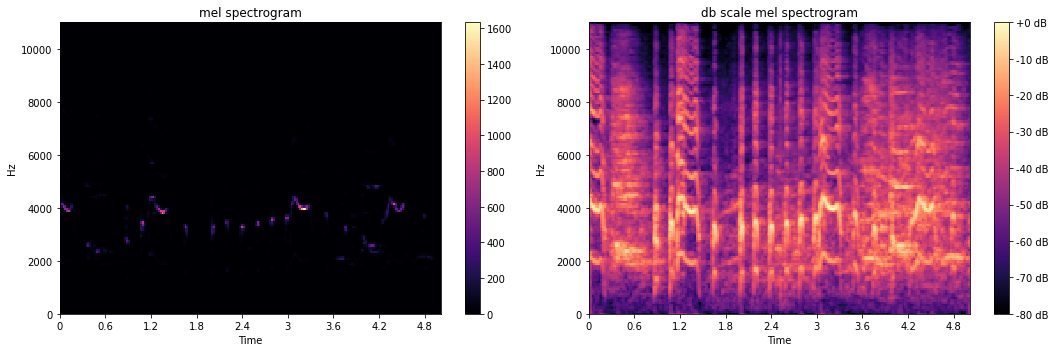

category : sneezing


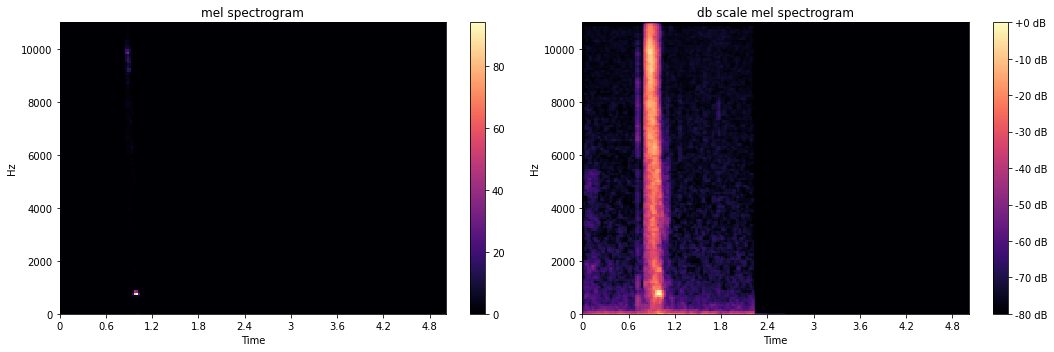

In [22]:
for row in meta_df.sample(frac=1)[['filename', 'category']][:3].iterrows():
    filename = row[1][0] # wavファイル名
    category = row[1][1] # そのファイルのカテゴリ

    waveform, sample_rate = librosa.load(drive_dir + "audio/" + filename)

    # メルスペクトログラムを求める
    feature_melspec = librosa.feature.melspectrogram(y=waveform, sr=sample_rate)

    print("category : " + category)
    plt.figure(figsize=(15,5))

    # librosa.feature.melspectrogramをそのまま可視化した場合
    plt.subplot(1,2,1)
    plt.title("mel spectrogram")
    librosa.display.specshow(feature_melspec, sr=sample_rate, x_axis='time', y_axis='hz')
    plt.colorbar()

    # デシベルスケールに変換した場合
    plt.subplot(1,2,2)
    plt.title("db scale mel spectrogram")
    feature_melspec_db = librosa.power_to_db(feature_melspec, ref=np.max)
    librosa.display.specshow(feature_melspec_db, sr=sample_rate, x_axis='time', y_axis='hz')
    plt.colorbar(format='%+2.0f dB')

    plt.tight_layout()
    plt.show()

# CNNで分類してみる

[参考記事](https://medium.com/@hasithsura/audio-classification-d37a82d6715)を参考にしながら、CNNで環境音の分類に挑戦してみる

特徴量はメルスペクトログラムを使用する

In [14]:
meta_df.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


In [15]:
# メルスペクトログラムを画像に変換する
class ESC50Data(Dataset):
    def __init__(self, base_path, df, in_col, out_col):
        self.df = df
        self.data = [] # 音源データをメルスペクトログラム（画像）に変換して格納する用
        self.labels = [] # 各データのカテゴリー情報を格納する
        self.category2id={}
        self.id2category={}
        self.categories = list(sorted(df[out_col].unique())) # 正解ラベル格納用（５０ラベル）
        # ラベルをIDに変換する辞書を作成
        for i, category in enumerate(self.categories):
            self.category2id[category] = i
            self.id2category[i] = category


        for row in tqdm(range(len(df))):
            row = df.iloc[row]
            file_path = os.path.join(base_path, row[in_col])
            waveform, sr = librosa.load(file_path)
            feature_melspec = librosa.feature.melspectrogram(y=waveform, sr=sr)
            feature_melspec_db = librosa.power_to_db(feature_melspec, ref=np.max)
            self.data.append(feature_melspec_db)
            self.labels.append(self.category2id[row['category']])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

train_df, test_df = train_test_split(meta_df, train_size=0.8)
train_data = ESC50Data(drive_dir + "audio/", train_df, 'filename', 'category')
test_data = ESC50Data(drive_dir + "audio/", test_df, 'filename', 'category')

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)

100%|██████████| 400/400 [02:58<00:00,  2.24it/s]


In [16]:
import pickle
with open(drive_dir + "melspec_db_train_loader", 'wb') as w:
    pickle.dump(train_loader, w)
with open(drive_dir + "melspec_db_test_loader", 'wb') as w:
    pickle.dump(test_loader, w)

## 自前で畳み込みネットワークを用意してみる

In [35]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 128, 8)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(128, 256, 5)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256*28*104, 1000)
        self.fc2 = nn.Linear(1000, 100)
        self.fc3 = nn.Linear(100, 50)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 256*28*104)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return x

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = Net().to(device)
loss_function = nn.CrossEntropyLoss()
lr = 2e-4
optimizer = optim.Adam(net.parameters(), lr=lr)

RuntimeError: ignored

In [34]:
losses = []
for epoch in range(50):

    train_losses = 0
    # 学習
    for data in train_loader:
        optimizer.zero_grad()
        x, y = data
        x = x.to(device, dtype=torch.float32)
        y = y.to(device)
        x = x.unsqueeze(1)
        out = net(x)
        loss = loss_function(out, y)
        loss.backward()
        optimizer.step()
        train_losses += loss.item()
    
    test_losses = 0
    actual_list, predict_list = [], []
    # 検証
    for data in test_loader:
        with torch.no_grad():
            x, y = data
            x = x.to(device, dtype=torch.float32)
            y = y.to(device)
            x = x.unsqueeze(1)
            out = net(x)
            loss = loss_function(out, y)
            _, y_pred = torch.max(out, 1)
            test_losses += loss.item()

            actual_list.append(y.cpu().numpy())
            predict_list.append(y_pred.cpu().numpy())

    actual_list = np.concatenate(actual_list)
    predict_list = np.concatenate(predict_list)
    accuracy = np.mean(actual_list == predict_list)


    print("epoch", epoch, "\t train_loss", train_losses, "\t test_loss", test_losses, "\t accuracy", accuracy)

RuntimeError: ignored

## 学習みモデルを使ってみる(ResNet)

In [3]:
from torchvision.models import resnet34

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


resnet_model = resnet34(pretrained=True)
# 最後の層の次元を今回のカテゴリ数に変更する
resnet_model.fc = nn.Linear(512,50)

# 最初の畳み込みのチャネル3をチャネル1に変更する
resnet_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
resnet_model = resnet_model.to(device)


loss_function = nn.CrossEntropyLoss()
lr = 2e-4
optimizer = optim.Adam(resnet_model.parameters(), lr=lr)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [18]:
losses = []
for epoch in range(50):

    train_losses = 0
    # 学習
    for data in train_loader:
        optimizer.zero_grad()
        x, y = data
        x = x.to(device, dtype=torch.float32)
        y = y.to(device)
        x = x.unsqueeze(1)
        out = resnet_model(x)
        loss = loss_function(out, y)
        loss.backward()
        optimizer.step()
        train_losses += loss.item()
    
    test_losses = 0
    actual_list, predict_list = [], []
    
    # 検証
    for data in test_loader:
        with torch.no_grad():
            x, y = data
            x = x.to(device, dtype=torch.float32)
            y = y.to(device)
            x = x.unsqueeze(1)
            out = resnet_model(x)
            loss = loss_function(out, y)
            _, y_pred = torch.max(out, 1)
            test_losses += loss.item()

            actual_list.append(y.cpu().numpy())
            predict_list.append(y_pred.cpu().numpy())

    actual_list = np.concatenate(actual_list)
    predict_list = np.concatenate(predict_list)
    accuracy = np.mean(actual_list == predict_list)


    print("epoch", epoch, "\t train_loss", train_losses, "\t test_loss", test_losses, "\t accuracy", accuracy)

epoch 0 	 train_loss 126.61780571937561 	 test_loss 21.01327872276306 	 accuracy 0.575
epoch 1 	 train_loss 51.59553635120392 	 test_loss 16.93894588947296 	 accuracy 0.6475
epoch 2 	 train_loss 27.610755309462547 	 test_loss 13.882235825061798 	 accuracy 0.71
epoch 3 	 train_loss 16.399369724094868 	 test_loss 14.29767906665802 	 accuracy 0.7175
epoch 4 	 train_loss 10.980505153536797 	 test_loss 12.397285878658295 	 accuracy 0.7275
epoch 5 	 train_loss 6.741484804078937 	 test_loss 12.815173774957657 	 accuracy 0.7325
epoch 6 	 train_loss 5.586890634149313 	 test_loss 12.801421403884888 	 accuracy 0.7325
epoch 7 	 train_loss 4.940334261395037 	 test_loss 14.615316689014435 	 accuracy 0.72
epoch 8 	 train_loss 5.41810249350965 	 test_loss 12.871053844690323 	 accuracy 0.725
epoch 9 	 train_loss 4.717587516643107 	 test_loss 13.196717858314514 	 accuracy 0.7325
epoch 10 	 train_loss 9.145377090200782 	 test_loss 12.598607301712036 	 accuracy 0.7425
epoch 11 	 train_loss 7.9061163291335